In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.coordinates as coord
from astropy.time import Time
from astropy import units as u

### Load up Gaia results
#### (see adql_query.txt for query)

In [2]:
gaia = np.genfromtxt('../hjhosts-result.csv', delimiter=',', unpack=True, names=True, dtype=None, encoding=None)

In [3]:
table = pd.DataFrame.from_records(gaia)

In [4]:
table = table.rename(columns={'col1':'kep_ra', 'col2':'kep_dec', 'col3':'kepmag'})

#### Calculate better angular separations that take propagated proper motion into account:

In [14]:
refCoord = coord.SkyCoord(ra=table['kep_ra'].values * u.degree, 
                          dec=table['kep_dec'].values * u.degree)        

In [15]:
table['radial_velocity'][np.isnan(table['radial_velocity'])] = 0.
gaia_time = Time(table['ref_epoch'], format='jyear')
gaiaCoord = coord.SkyCoord(ra=table['ra'].values * u.degree, 
                           dec=table['dec'].values * u.degree, 
                           distance=(table['parallax'].values * u.milliarcsecond).to(u.pc, u.parallax()),
                           radial_velocity=table['radial_velocity'].values * u.km / u.s,
                           pm_ra_cosdec=table['pmra'].values * u.milliarcsecond / u.year, 
                           pm_dec=table['pmdec'].values * u.milliarcsecond / u.year, 
                           obstime=gaia_time
                            )
sep = refCoord.separation(gaiaCoord)
ind = np.where(sep > 10. * u.deg)[0]
for i in ind:
        sep[i] = 180.*u.deg - sep[i] # HACK

/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/astropy/coordinates/angles.py:639: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/astropy/coordinates/angles.py:522: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site

In [17]:
table['ang_dist_w_pm'] = sep.arcsec

Check on the best matches:

In [18]:
matches = table.sort_values(['kep_ra', 'ang_dist_w_pm'], inplace=False)
matches.drop_duplicates('kep_ra', inplace=True)

(array([254.,   2.,   1.,   3.,   0.,   1.,   0.,   0.,   0.,   2.]),
 array([7.20163253e-03, 1.77337315e+00, 3.53954467e+00, 5.30571618e+00,
        7.07188770e+00, 8.83805922e+00, 1.06042307e+01, 1.23704022e+01,
        1.41365738e+01, 1.59027453e+01, 1.76689168e+01]),
 <a list of 10 Patch objects>)

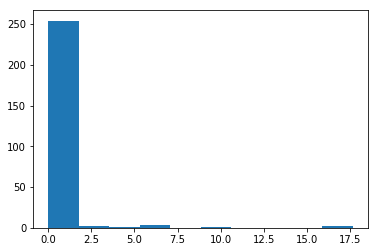

In [19]:
plt.hist(matches['ang_dist_w_pm'])